In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
from itertools import product
import sys

from Plot import Plot

vector.register_awkward() 
DATATYPE="mc"
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data"
SAMPLE_RUN = 291694
MUON_MASS = 0.105
D_ABS = 500

events_tree = f"{BASEDIR}/run{SAMPLE_RUN}.{DATATYPE}.root:eventsTree"

if DATATYPE=="mc":
    gen_tree = f"{BASEDIR}/run{SAMPLE_RUN}.{DATATYPE}.root:genTree"

In [2]:
def getTracks(events):
    return ak.zip({ "px":events["Muon_Px"],
                    "py":events["Muon_Py"],
                    "pz":events["Muon_Pz"],
                    "E":events["Muon_E"],
                    "DCAx":events["Muon_xDCA"],
                    "DCAy":events["Muon_yDCA"],
                    "DCAz":events["Muon_zDCA"],
                    "charge":events["Muon_Charge"],
                    "thetaAbs":events["Muon_thetaAbs"],
                    "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def getgenTracks(genevents):
    return ak.zip({ "px":genevents["Muon_GenPx"],
                    "py":genevents["Muon_GenPy"],
                    "pz":genevents["Muon_GenPz"],
                    "E":genevents["Muon_GenE"]},
                    with_name='Momentum4D')

In [3]:
def applySelection(data, criteria, plot=False, **kwargs):
    # Select data using function "criteria"
    selected = data[criteria(data)]
    if plot:
        hist_before = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        hist_after = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        try:
            hist_before.fill(ak.flatten(data.pt))
            hist_after.fill(ak.flatten(selected.pt))
        except AttributeError:
            hist_before.fill(ak.flatten(getTracks(data).pt))
            hist_after.fill(ak.flatten(getTracks(selected).pt))
        Plot(hist_before, hist_after, **kwargs)
    return selected

In [4]:
def get_pDCA_infos(goodTracks):
    DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
    p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
    pDCA=p0*DCA
    
    N=3 #choice of resolution should be a number between 1 and 10
    sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
    pRes= 0.0004 * goodTracks.p
    sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))

    thetaRes= 0.0005 * goodTracks.p
    sigmatheta= 535 * thetaRes

    #computing total resolution for pDCA
    sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

    goodTracks["pDCA"] = pDCA

    return pDCA, N, sigmapDCA

In [5]:
def analyzeEventsTree():
    for batch in uproot.iterate(events_tree,
                                ["zVtx", "nMuons", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_xDCA","Muon_yDCA","Muon_zDCA","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0]

        def select_charge(events):
            charge = []
            for charges in events["Muon_Charge"]:
                if (-1 in charges) and (1 in charges):
                    charge += [True]
                else:
                    charge += [False]
            return charge

        def select_z(events):
            z = events["zVtx"]
            return (z < 10) & (z > -10)

        select_nb = lambda events: events["nMuons"] >= 2

        goodEvents = applySelection(events, select_nb, plot=True, title="Nb selection")
        goodEvents = applySelection(goodEvents, select_z, plot=True, title="z selection")
        goodEvents = applySelection(goodEvents, select_charge, plot=True, title="charge selection")

        tracks = getTracks(goodEvents)

        select_pt = lambda tracks: tracks.pt > 1
        select_match = lambda tracks: tracks.matched >= 1
        select_eta = lambda tracks: (tracks.eta < -2.5) & (tracks.eta > -4)
        select_Rabs = lambda tracks: (D_ABS * np.abs(np.tan(tracks.thetaAbs)) < 90) & (D_ABS * np.abs(np.tan(tracks.thetaAbs)) > 17.5)
    
        
        goodTracks = applySelection(tracks, select_pt, plot=True, title="pt selection")
        goodTracks = applySelection(goodTracks, select_match, plot=True, title="match selection")
        goodTracks = applySelection(goodTracks, select_eta, plot=True, title="eta selection")
        goodTracks = applySelection(goodTracks, select_Rabs, plot=True, title="R_abs selection")

        pDCA, N, sigmapDCA = get_pDCA_infos(goodTracks)
        # for N in range(1, 15):
            # select_pDCA = lambda tracks: pDCA < N*sigmapDCA
            # goodTracks_ = applySelection(goodTracks, select_pDCA, plot=True, title=f"pDCA selection, N = {N}")
        select_pDCA = lambda tracks: pDCA < N*sigmapDCA
        goodTracks_ = applySelection(goodTracks, select_pDCA, plot=True, title=f"pDCA selection, N = {N}")
        invariant_mass = []
        # Pair tracks and calculate invarant mass
        for eventTracks in goodTracks:
            if len(eventTracks) < 2: continue
            positive = eventTracks[eventTracks.charge == 1] #Tracks with positive charge
            negative = eventTracks[eventTracks.charge == -1] #Tracks with negative charge
            matched_pair = [] # List to store tracks already paired
            for p, n in product(positive, negative):
                if p in matched_pair or n in matched_pair: continue
                if abs(p.pDCA - n.pDCA) < 100: # Trouver une meilleure coupure
                    invariant_mass.append(np.sqrt(2*MUON_MASS**2 + 2*p.dot(n)))
                    matched_pair.append(p)
                    matched_pair.append(n)
                    
                            
        mass_hist = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=5,name='$|pt|$'))
        mass_hist.fill(invariant_mass)
        Plot(mass_hist, title="Invariant mass", save=True)

        # Plot(vhMagRaw, vhMagRaw2, labelx=r"zVtx", save=True, savename="zVtx_cut")


In [6]:
def analyzeGenTree():
    assert gen_tree
    for batch in uproot.iterate(gen_tree,
                                ["zVtxMC", "nMuonsGen", "Muon_GenPx","Muon_GenPy","Muon_GenPz","Muon_GenE","Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 report=True):
        events = batch[0]
        print(dir(events))
        hist_E = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|pt|$'))
        hist_E.fill(ak.flatten(events.Muon_GenE))
        hist_z = hist.Hist(hist.axis.Regular(bins=100,start=-20,stop=20,name='z'))
        hist_z.fill(events.zVtxMC)

        codes = ak.flatten(events.Muon_GenMotherPDGCode)
        print(sum(codes == 443))
        print(sum(codes == 100443))
        
        Plot(hist_E)
        Plot(hist_z)

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


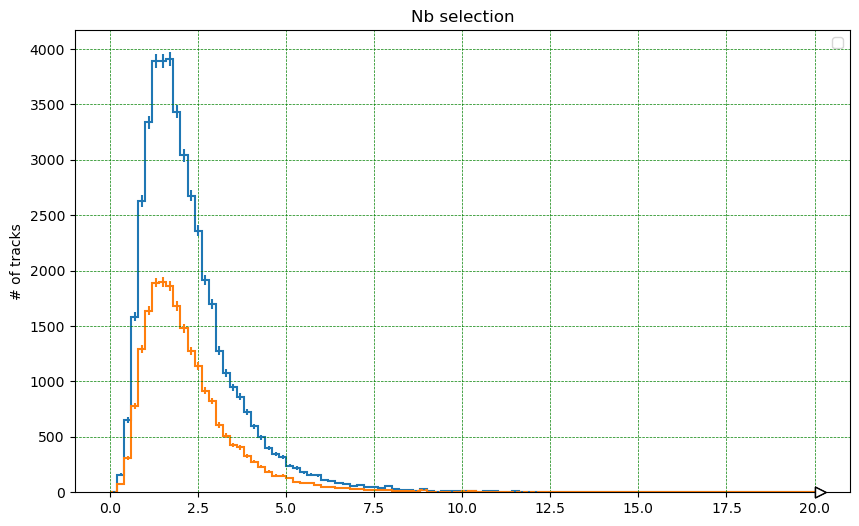

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


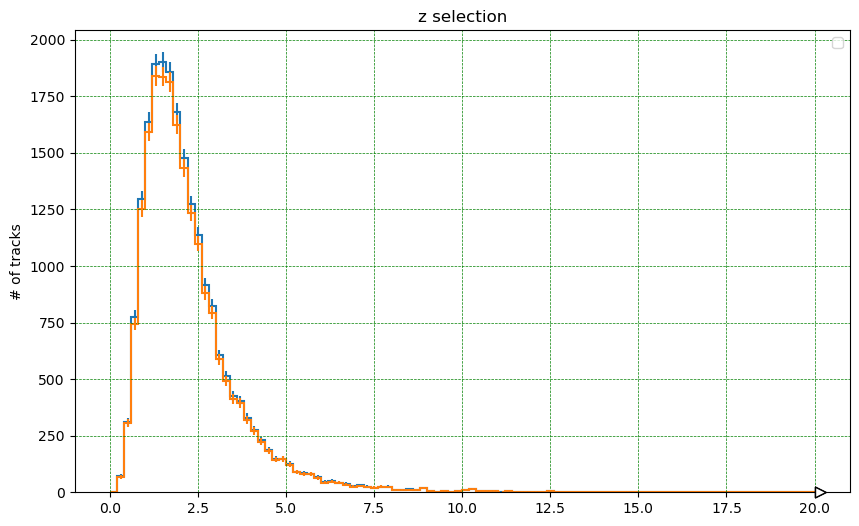

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


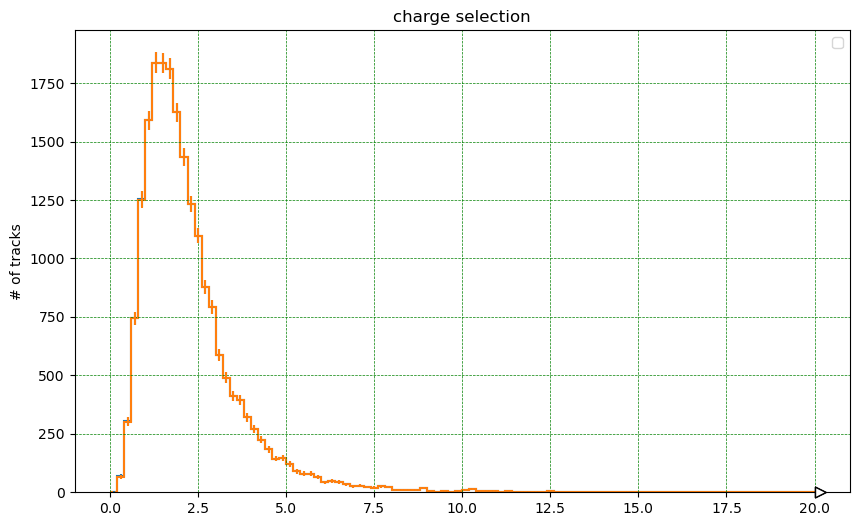

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


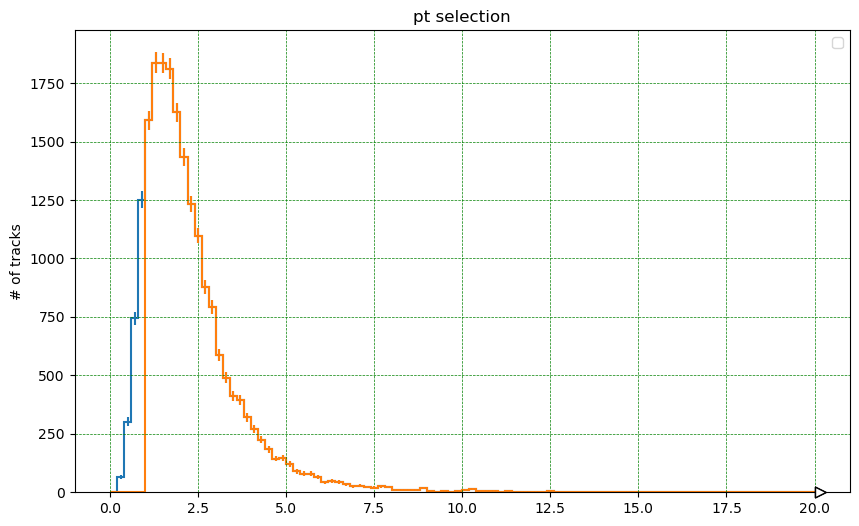

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


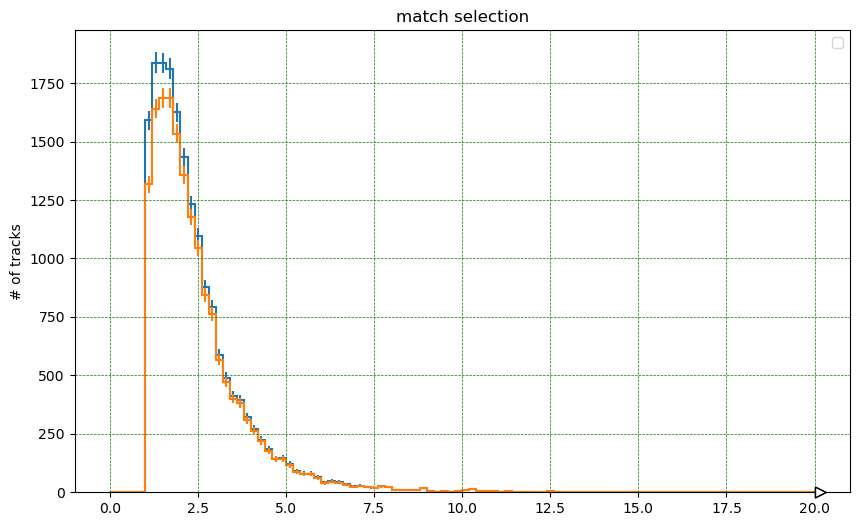

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


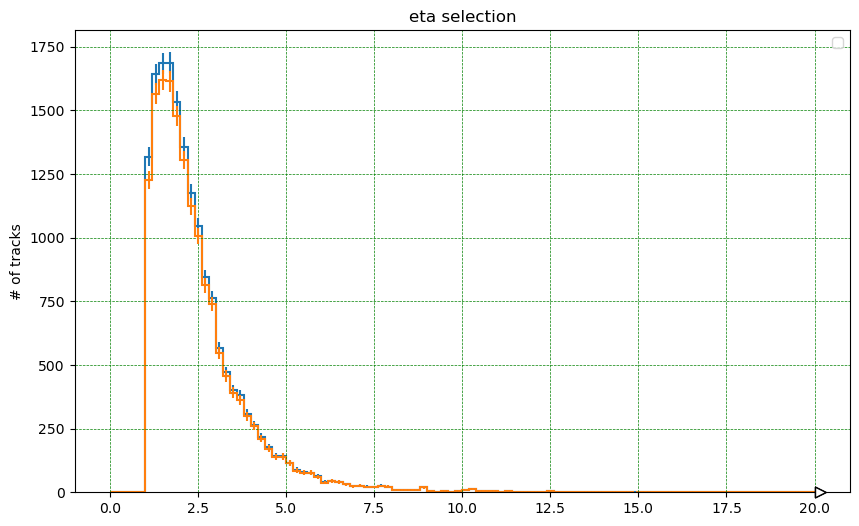

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


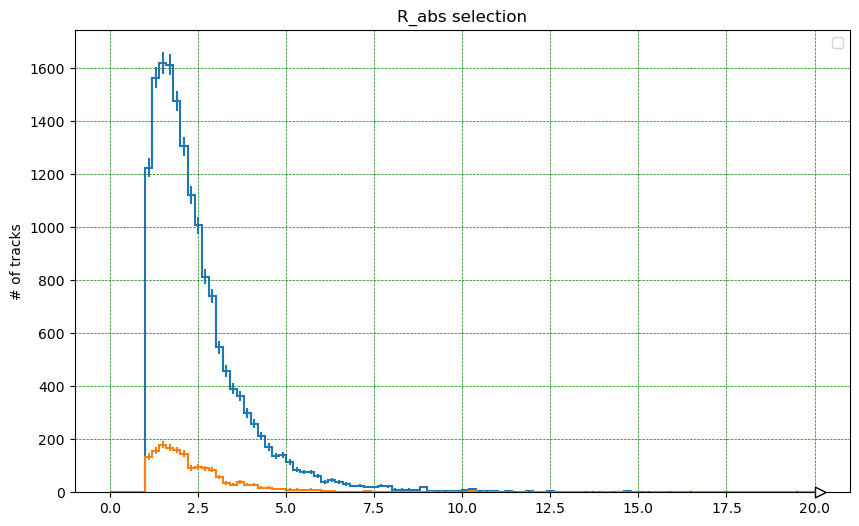

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


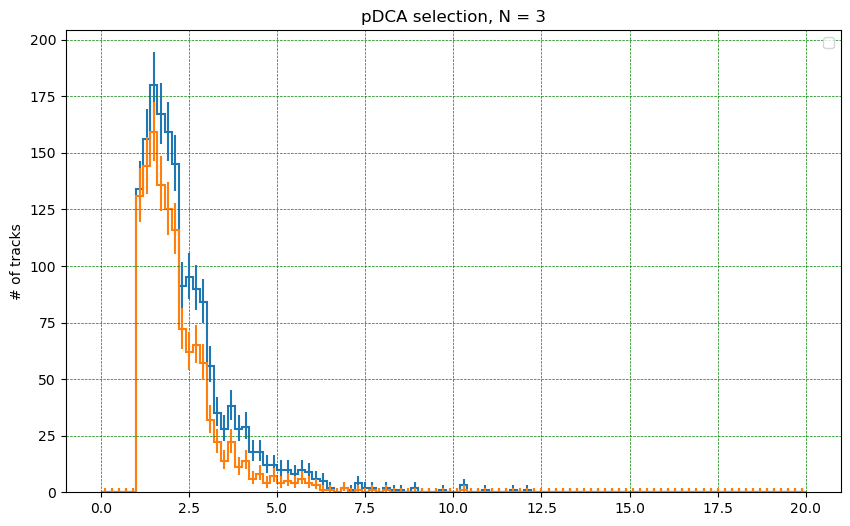

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


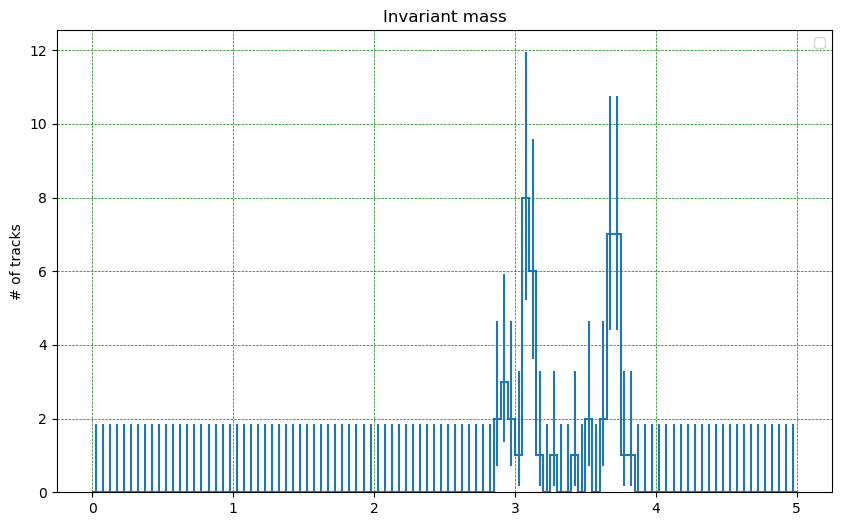

In [7]:
analyzeEventsTree()

['Mask', 'Muon_GenE', 'Muon_GenLabel', 'Muon_GenMotherPDGCode', 'Muon_GenPx', 'Muon_GenPy', 'Muon_GenPz', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__self_class__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__thisclass__', '_attrs', '_behavior', '_cpp_type', '_layout', '_numbaview', 'attrs', 'behavior', 'cpp_type', 'fields', 'is_tuple', 'layout', 'mask', 'nMuonsGen', 'nbytes', 'ndim', 'numba_type', 'show', 'to_list', 'to_numpy', 'tolist', 'type', 'typestr', 'zVtxMC']
53338
26662


/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


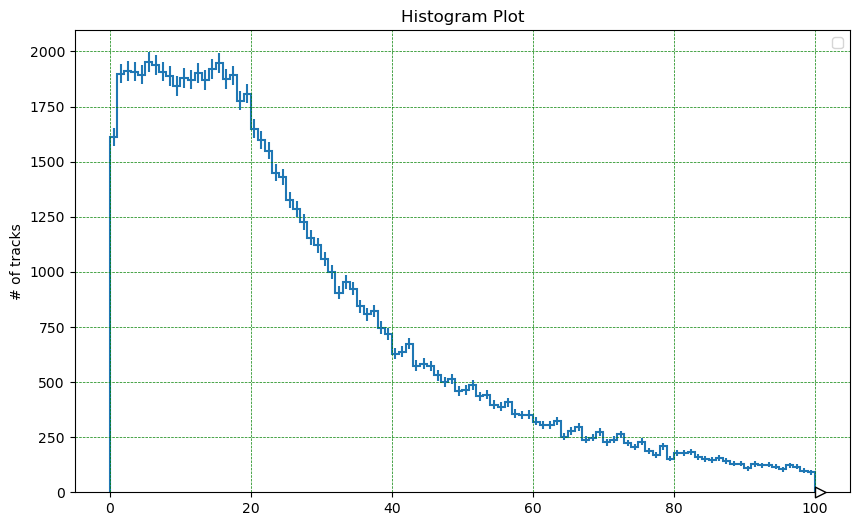

/pbs/home/s/subatech05/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


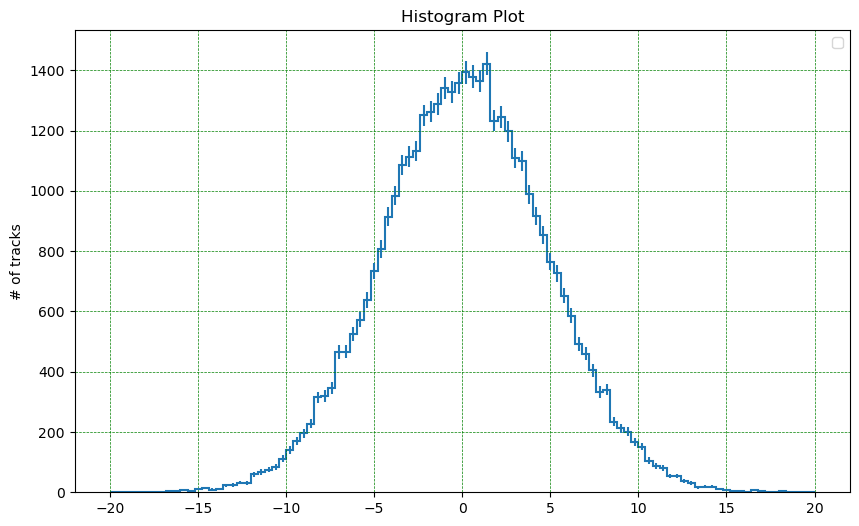

In [8]:
analyzeGenTree()